In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mctorch
import mctorch.optim as moptim
import OurMethod
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize

In [2]:
N = 1000
theta = np.random.uniform(0, 2*np.pi, N)
r = np.sqrt(np.random.uniform(0, 1, N))
x = r * np.cos(theta)
y = r * np.sin(theta)
data = np.stack([x, y], axis=1)
labels = x**2 + y**2
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
model = MLP()

learning_rate = 0.001
num_epochs = 5000
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [5]:
loss_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(data_tensor)
    loss = criterion(output, labels_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 500/5000, Loss: 0.000075
Epoch 1000/5000, Loss: 0.000030
Epoch 1500/5000, Loss: 0.000020
Epoch 2000/5000, Loss: 0.000015
Epoch 2500/5000, Loss: 0.000011
Epoch 3000/5000, Loss: 0.000009
Epoch 3500/5000, Loss: 0.000007
Epoch 4000/5000, Loss: 0.000006
Epoch 4500/5000, Loss: 0.000005
Epoch 5000/5000, Loss: 0.000005


Training completed: 5000 epochs, learning rate = 0.001, final training loss = 0.000005


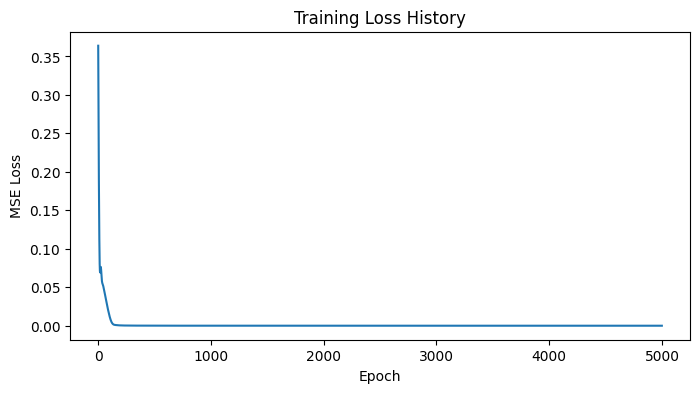

In [6]:
final_loss = loss_history[-1]
print(f"Training completed: {num_epochs} epochs, learning rate = {learning_rate}, final training loss = {final_loss:.6f}")

plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss History")
plt.show()

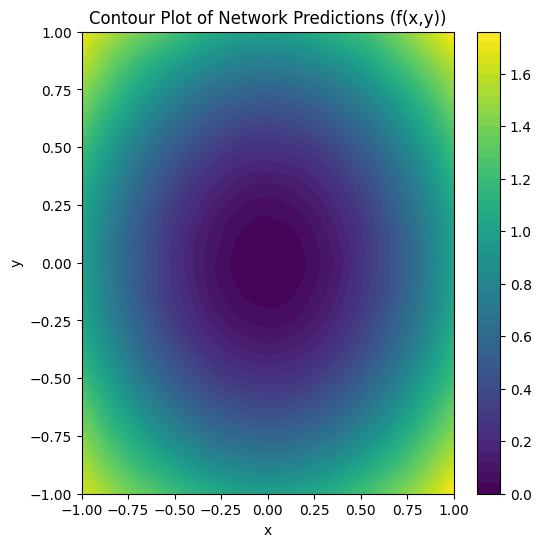

In [7]:
grid_points = 100
x_test = np.linspace(-1, 1, grid_points)
y_test = np.linspace(-1, 1, grid_points)
X_test, Y_test = np.meshgrid(x_test, y_test)
test_data = np.stack([X_test.ravel(), Y_test.ravel()], axis=1)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
model.eval()
with torch.no_grad():
    preds_test = model(test_tensor).squeeze().numpy().reshape(X_test.shape)

plt.figure(figsize=(6,6))
contour = plt.contourf(X_test, Y_test, preds_test, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of Network Predictions (f(x,y))")
plt.show()

In [8]:
def mlp_scalar_func(pt):
    pt_tensor = torch.tensor(pt[None, :], dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        val = model(pt_tensor).item()
    return val

In [9]:
epsilon = 1e-6
grads_list = []
for pt in data:
    df = scipy.optimize.approx_fprime(pt, mlp_scalar_func, epsilon)
    grads_list.append(df)

grads = np.array(grads_list)

In [10]:
poly = PolynomialFeatures(degree=1, include_bias=False)
x_np = data[:, 0]
y_np = data[:, 1]
f_x = grads[:, 0]
f_y = grads[:, 1]

extB = np.column_stack([
    x_np * f_x,
    y_np * f_x,
    f_x,
    x_np * f_y,
    y_np * f_y,
    f_y
])

#U, S, Vt = np.linalg.svd(extB, full_matrices=False)
#P = Vt[-1, :]

In [11]:
extB = torch.tensor(extB).float()
p = OurMethod.tryDimV(extB, 1, criterion=torch.nn.L1Loss(), optimizer=moptim.rAdagrad)

/home/ben/.local/lib/python3.12/site-packages/mctorch/nn/manifolds/stiefel.py:50: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  q, r = torch.qr(X)


In [12]:
P = np.array(p[1].detach())

In [13]:
print("Recovered infinitesimal generator coefficients (up to scale):")
print(f"a: {P[0][0]:.4f}, b: {P[1][0]:.4f}, c: {P[2][0]:.4f}, d: {P[3][0]:.4f}, e: {P[4][0]:.4f}, f: {P[5][0]:.4f}")
print("Ground truth coefficients for rotation (-y, x): a=0, b=-1, c=0, d=1, e=0, f=0")

Recovered infinitesimal generator coefficients (up to scale):
a: 0.0012, b: -0.7075, c: 0.0002, d: 0.7067, e: -0.0058, f: -0.0005
Ground truth coefficients for rotation (-y, x): a=0, b=-1, c=0, d=1, e=0, f=0


Mean absolute directional derivative along (-y, x): 0.043497
Standard deviation of directional derivative: 0.060946


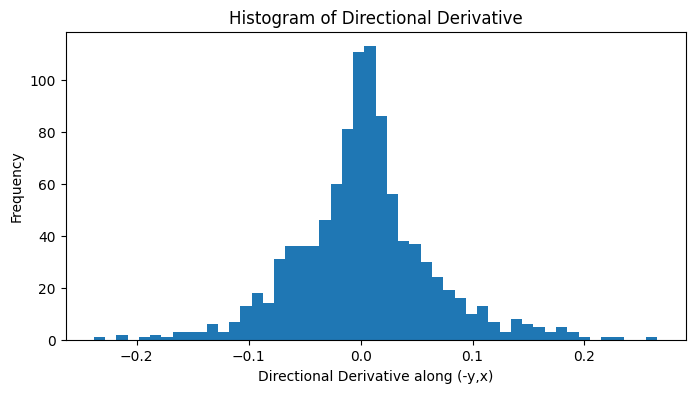

In [14]:
directional_deriv = -y_np * f_x + x_np * f_y
mean_deriv = np.mean(np.abs(directional_deriv))
std_deriv = np.std(directional_deriv)

print(f"Mean absolute directional derivative along (-y, x): {mean_deriv:.6f}")
print(f"Standard deviation of directional derivative: {std_deriv:.6f}")

plt.figure(figsize=(8,4))
plt.hist(directional_deriv, bins=50)
plt.xlabel("Directional Derivative along (-y,x)")
plt.ylabel("Frequency")
plt.title("Histogram of Directional Derivative")
plt.show()